In [9]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [4]:
tf.config.threading.set_inter_op_parallelism_threads(6)
tf.config.threading.set_intra_op_parallelism_threads(2)

# path to the model weights files.
weights_path = '/home/user/models/pretrained/vgg16_weights.h5'
top_model_weights_path = '/home/user/models/top_tuned/bottleneck_fc_model_2class.h5'
# dimensions of our images.
img_width, img_height = 224, 224

train_data_dir = '/home/user/Документы/convnets/transfer-learning-keras/dataset/training'
validation_data_dir = '/home/user/Документы/convnets/transfer-learning-keras/dataset/validation'
evaluation_data_dir = '/home/user/Документы/convnets/transfer-learning-keras/dataset/evaluation'
nb_train_samples = 3000
nb_validation_samples = 1000
nb_evaluation_samples = 1000
epochs = 10
batch_size = 20

# build the VGG16 network
base_model = applications.VGG16(weights='imagenet', include_top=False, 
                               input_tensor=Input(shape=(224, 224, 3)))
print('VGG16 model loaded.')

VGG16 model loaded.


In [5]:
# build a classifier model to put on top of the convolutional model
top_model = base_model.output
top_model = Flatten(name='flatten')(top_model)
top_model = Dense(512, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(1, activation='sigmoid')(top_model)

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning

# add the model on top of the convolutional base
model = Model(inputs=base_model.input, outputs=top_model)

# set the first 15 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in base_model.layers:
    layer.trainable = False
for layer in model.layers:
    print("{}: {}".format(layer, layer.trainable))

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f45bc2b58d0>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f45bc323d50>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f45bc2b5f10>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f45bc2bf2d0>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f45bc2c4990>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f45bc2d25d0>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f45bc2e20d0>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f45bc2e8e90>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f45bc276450>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f45bc280750>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f45bc292650>: False
<tensorflow.python.keras.layers.convolutional.Conv2D

In [6]:
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
)

test_datagen = ImageDataGenerator()
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
train_datagen.mean = mean
test_datagen.mean = mean

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    color_mode="rgb",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    color_mode="rgb",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    evaluation_data_dir,
    color_mode="rgb",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary')

print("[INFO] training head...")
H = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
[INFO] training head...
Epoch 1/10
150/150 [==============================] - 287s 2s/step - loss: 2.2250 - acc: 0.8520 - val_loss: 0.4303 - val_acc: 0.9630
Epoch 2/10
150/150 [==============================] - 287s 2s/step - loss: 0.7219 - acc: 0.9100 - val_loss: 0.3328 - val_acc: 0.9600
Epoch 3/10
150/150 [==============================] - 280s 2s/step - loss: 0.4309 - acc: 0.9227 - val_loss: 0.2112 - val_acc: 0.9570
Epoch 4/10
150/150 [==============================] - 278s 2s/step - loss: 0.3303 - acc: 0.9273 - val_loss: 0.1986 - val_acc: 0.9600
Epoch 5/10
150/150 [==============================] - 273s 2s/step - loss: 0.2200 - acc: 0.9357 - val_loss: 0.1703 - val_acc: 0.9610
Epoch 6/10
150/150 [==============================] - 283s 2s/step - loss: 0.2095 - acc: 0.9390 - val_loss: 0.1706 - val_acc: 0.9590
Epoch 7/10
150/150 [==============================] 

In [7]:
model.save_weights('/home/user/models/fine_tuned/fine_tuned_2class.h5')

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


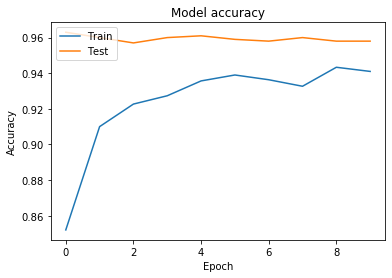

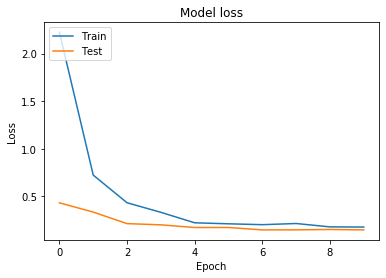

In [11]:
plot_model(model, to_file='model.png')
    # Plot training & validation accuracy values
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

    # Plot training & validation loss values
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
for layer in base_model.layers[15:]:
    layer.trainable = True
for layer in model.layers:
    print("{}: {}".format(layer, layer.trainable))

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f45bc2b58d0>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f45bc323d50>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f45bc2b5f10>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f45bc2bf2d0>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f45bc2c4990>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f45bc2d25d0>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f45bc2e20d0>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f45bc2e8e90>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f45bc276450>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f45bc280750>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f45bc292650>: False
<tensorflow.python.keras.layers.convolutional.Conv2D

In [16]:
train_generator.reset()
validation_generator.reset()
print("[INFO] re-compiling model...")
opt = optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])
print("[INFO] training with last conv block...")
H = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=7,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

[INFO] re-compiling model...
[INFO] training with last conv block...
Epoch 1/7
150/150 [==============================] - 320s 2s/step - loss: 0.1616 - acc: 0.9470 - val_loss: 0.1243 - val_acc: 0.9650
Epoch 2/7
150/150 [==============================] - 319s 2s/step - loss: 0.1285 - acc: 0.9580 - val_loss: 0.1283 - val_acc: 0.9650
Epoch 3/7
150/150 [==============================] - 341s 2s/step - loss: 0.0934 - acc: 0.9657 - val_loss: 0.1108 - val_acc: 0.9710
Epoch 4/7
150/150 [==============================] - 328s 2s/step - loss: 0.0756 - acc: 0.9697 - val_loss: 0.1141 - val_acc: 0.9710
Epoch 5/7
150/150 [==============================] - 327s 2s/step - loss: 0.0790 - acc: 0.9747 - val_loss: 0.0946 - val_acc: 0.9720
Epoch 6/7
150/150 [==============================] - 323s 2s/step - loss: 0.0676 - acc: 0.9763 - val_loss: 0.1105 - val_acc: 0.9750
Epoch 7/7
150/150 [==============================] - 328s 2s/step - loss: 0.0805 - acc: 0.9730 - val_loss: 0.1088 - val_acc: 0.9740


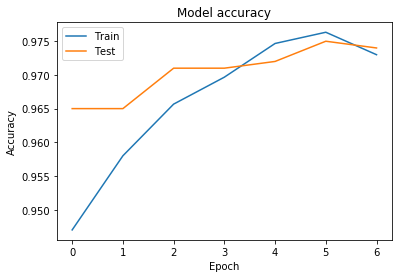

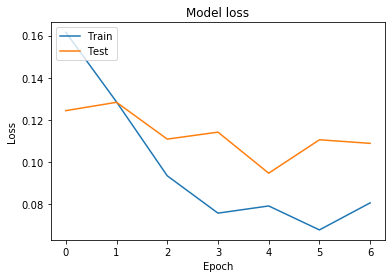

In [17]:
model.save_weights('/home/user/models/fine_tuned/fine_tuned_2class_full.h5')
    # Plot training & validation accuracy values
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

    # Plot training & validation loss values
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()